In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

## Linear Classifier

In [2]:
X, y = make_classification(n_samples=1000, 
                           n_features=2, 
                           n_redundant=0, 
                           n_informative=2, 
                           random_state=1, 
                           n_clusters_per_class=1,
                           class_sep=2)

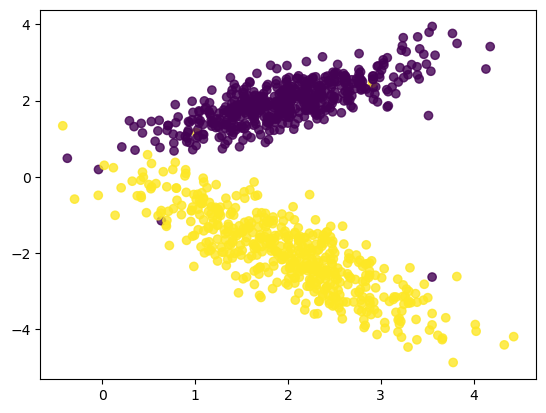

In [3]:
plt.scatter(X[:,0], X[:, 1], c=y, alpha=0.8)

In [4]:
class LinearClassifier:

    def __init__(self, input_size) -> None:
        self.weights = np.random.randn(input_size, 1)*0.1

    def forward(self, x):
        return np.dot(x, self.weights).reshape(-1, 1)
    
    def predict(self, x):
        return np.where(self.forward(x) > 0, 1, 0)
    
    def train(self, x, y, n_iter=1000, lr=0.01):
        for _ in range(n_iter):
            self.train_step(x, y, lr)

        return self
    
    def train_step(self, x, y, lr):
        # size of x: (N, D)
        # size of y: (N, 1)
        # size of w: (D, 1)

        diff = -y.reshape(-1, 1) + self.sigmoid(self.forward(x)) # (N, 1)
        grad = x.T@diff

        self.weights -= lr*grad

    def score(self, x, y):
        preds = self.predict(x).flatten()
        return np.mean(preds==y)

    @staticmethod
    def sigmoid(x):
        return 1/(1+np.exp(-x))


In [5]:
X = np.concatenate([np.ones((1000, 1)), X], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = LinearClassifier(3)

In [8]:
model.train(X_train, y_train)

In [9]:
model.score(X_train, y_train)

0.995

In [10]:
model.score(X_test, y_test)

0.985

## MLP

In [11]:
class InputLayer:
    def __init__(self, values):
        self.values = values

    def backward(self, *args, **kwargs):
        pass

    def step(self, *args, **kwargs):
        pass

In [125]:
class LinearLayer:
    def __init__(self, input_size, output_size, eta=1e-3, random_state=None):
        np.random.seed(random_state)
        self.weights = np.random.normal(scale=0.1, size=(output_size, input_size+1))
        self.gradient = np.zeros_like(self.weights)
        self.eta = eta

    def __call__(self, input_layer):
        self.input_layer = input_layer
        self.D = input_layer.values.shape[1]
        self.values = self.weights@np.vstack([np.ones((1, self.D)), input_layer.values])
        return self

    def backward(self, input_gradient):
        self.gradient = input_gradient@np.vstack([np.ones((1, self.D)), self.input_layer.values]).T
        gradient_back = (self.weights[:, 1:]).T@input_gradient
        self.input_layer.backward(gradient_back)

    def step(self):
        self.weights = self.weights - self.eta*self.gradient
        self.gradient = np.zeros_like(self.weights)
        self.input_layer.step()  

In [126]:
class ActivationLayer:
    def __init__(self, activation_function, derivative):
        self.function = activation_function
        self.derivative = derivative

    def __call__(self, input_layer):
        self.input_layer = input_layer
        self.values = self.function(input_layer.values)
        return self

    def backward(self, input_gradient):
        self.gradient = self.derivative(self.input_layer.values)*input_gradient
        self.input_layer.backward(self.gradient)

    def step(self):
        del self.gradient
        self.input_layer.step()

In [240]:
def softmax(logits):
    max_val = np.max(logits, axis=0)
    return np.exp(logits-max_val)/np.exp(logits-max_val).sum(axis=0)

In [175]:
class LossLayer:
    def __init__(self):
        self.pred_layer = None
        self.gt = None

    def __call__(self, gt, pred_layer):
        probs = softmax(pred_layer.values)
        self.gradient = probs.copy()
        self.gradient[gt, np.arange(gt.shape[0])] -= 1
        self.pred_layer = pred_layer
        return -np.log(probs[gt, np.arange(gt.shape[0])]).mean()

    def backward(self):
        self.pred_layer.backward(self.gradient)

    def step(self):
        self.pred_layer.step()

In [ ]:
def ReLU(input_values):
    return np.maximum(input_values, 0)

def ReLU_derivative(input_values):
    return np.where(input_values < 0, 0, 1)

In [194]:
class MLP:
    def __init__(self, input_size, output_size, *, hidden_size, n_layers):
        self.layers = []
        self.layers.append(LinearLayer(input_size, hidden_size))
        self.layers.append(ActivationLayer(ReLU, ReLU_derivative))

        for _ in range(n_layers-1):
            self.layers.append(LinearLayer(hidden_size, hidden_size))
            self.layers.append(ActivationLayer(ReLU, ReLU_derivative))

        self.layers.append(LinearLayer(hidden_size, output_size))
        self.loss_layer = LossLayer()

    def __call__(self, input_values):
        input_x = InputLayer(input_values)
        for layer in self.layers:
            input_x = layer(input_x)
        return input_x
    
    def train_step(self, x, y):
        logits = self(x)
        loss = self.loss_layer(y, logits)
        self.loss_layer.backward()
        self.loss_layer.step()

        return loss
    
    def train(self, x, y, *, n_iter=1000, print_every=100):
        for _ in range(n_iter):
            loss = self.train_step(x, y)
            if _ % print_every == 0:
                print(loss)
        return self
    
    def predict(self, x):
        return self(x).values.argmax(axis=0)
    
    def score(self, x, y):
        preds = self.predict(x).flatten()
        return np.mean(preds==y)

In [195]:
from sklearn.datasets import load_iris

In [196]:
iris_ds = load_iris()

In [197]:
X = iris_ds['data']
y = iris_ds.target

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [199]:
X_train = X_train.T
X_test = X_test.T

In [218]:
model = MLP(4, 3, hidden_size=10, n_layers=4)

In [219]:
model.train(X_train, y_train, n_iter=10000, print_every=1000)

1.0989304933366806
0.2212883994574652
0.05719200545958388
0.06008014696925955
0.047976090797126426
0.05339130999882169
0.05089651937997343
0.050783165116039856
0.05250609530173671
0.05688407542983755


In [220]:
model.score(X_train, y_train)

0.9666666666666667

In [221]:
model.score(X_test, y_test)

0.9666666666666667

## MLP for Image Classification

In [224]:
import sys
import gzip
import pickle

In [227]:
def load_mnist(fname="../mnist.pkl.gz"):
    f = gzip.open(fname, 'rb')

    if(sys.version_info.major==2):
        train_set, valid_set, test_set = pickle.load(f) # compatibility issue between python 2.7 and 3.4
    else:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin-1') # compatibility issue between python 2.7 and 3.4
    f.close()

    # Shuffle
    train_X = train_set[0]
    train_y = train_set[1]
    valid_X = valid_set[0]
    valid_y = valid_set[1]

    train_perm = np.random.permutation(train_X.shape[0])
    train_set = [train_X[train_perm,:],train_y[train_perm]]

    valid_perm = np.random.permutation(valid_X.shape[0])
    valid_set = [valid_X[valid_perm,:],valid_y[valid_perm]]

    return train_set, valid_set, test_set

In [230]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_mnist()

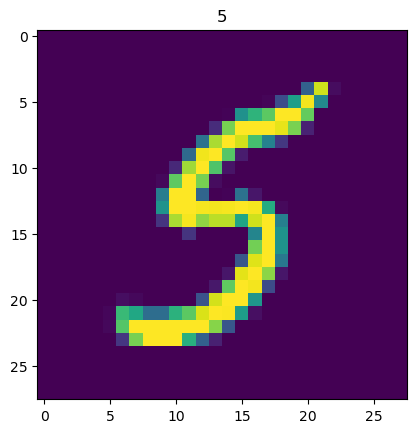

In [236]:
plt.imshow(X_train[0].reshape(28,28))
plt.title(y_train[0])
plt.show()

In [264]:
model = MLP(784, 10, hidden_size=50, n_layers=4)

In [265]:
losses = []
train_accs = []
val_accs = []
for epoch in range(10):
    print("Epoch: ", epoch+1)

    # Training
    tot_loss = 0
    for i in range(0, X_train.shape[0], 100):
        loss = model.train_step(X_train[i:i+100].T, y_train[i:i+100])
        tot_loss += loss*len(y_train[i:i+100])/len(y_train)

    # Evaluation
    train_acc = model.score(X_train.T, y_train)
    val_acc = model.score(X_val.T, y_val)

    print("Training loss: ", tot_loss)
    print("Training accuracy: ", train_acc)
    print("Validation accuracy: ", val_acc)

    losses.append(tot_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

Epoch:  1
Training loss:  1.0174273012473494
Training accuracy:  0.8944
Validation accuracy:  0.9041
Epoch:  2
Training loss:  0.2838818455510397
Training accuracy:  0.93642
Validation accuracy:  0.9394
Epoch:  3
Training loss:  0.19834527948773917
Training accuracy:  0.95242
Validation accuracy:  0.9518
Epoch:  4
Training loss:  0.15782546053266852
Training accuracy:  0.96104
Validation accuracy:  0.9581
Epoch:  5
Training loss:  0.13259720738712397
Training accuracy:  0.96722
Validation accuracy:  0.9626
Epoch:  6
Training loss:  0.11457834258174407
Training accuracy:  0.97206
Validation accuracy:  0.9655
Epoch:  7
Training loss:  0.10036239301891264
Training accuracy:  0.97458
Validation accuracy:  0.9664
Epoch:  8
Training loss:  0.0891411118686463
Training accuracy:  0.97596
Validation accuracy:  0.9667
Epoch:  9
Training loss:  0.07988429060730921
Training accuracy:  0.97784
Validation accuracy:  0.9673
Epoch:  10
Training loss:  0.07184939673136619
Training accuracy:  0.97854
Va

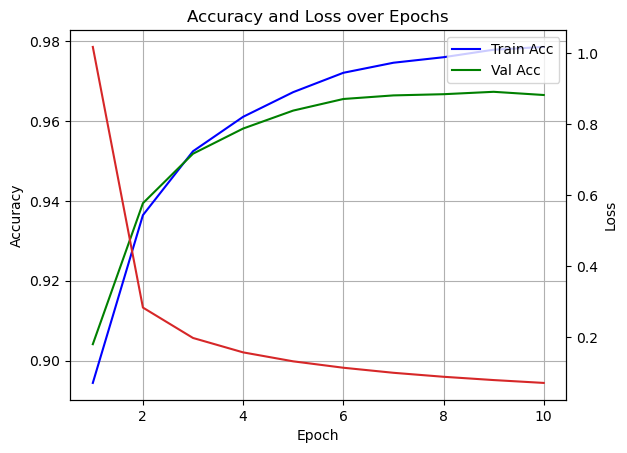

In [291]:
# Creating the plot
fig, ax1 = plt.subplots()

# Plotting the accuracy on the primary y-axis
color = 'tab:Blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
# ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(np.arange(1,11), train_accs, color='blue', label='Train Acc')
ax1.plot(np.arange(1,11), val_accs, color='green', label='Val Acc')

# Creating a secondary y-axis for the loss
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Loss')  
ax2.plot(np.arange(1,11), losses, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# Showing the plot
plt.title('Accuracy and Loss over Epochs')
ax1.legend(loc='upper right')
ax1.grid()
plt.show()